In [2]:
import numpy as np
import os

import matplotlib.pyplot as plt
%matplotlib inline

from astropy.table import Table
from astropy import units as u
import astropy.constants
from astropy.io import ascii,fits

from telfit import Modeler

import scipy.ndimage as scipynd
from scipy.optimize import curve_fit
from astropy import  convolution


DEIMOS_DROPBOX = '/Users/mgeha/Dropbox/DEIMOS/'


Create telluric synthetic models, binned at 0.02AA.   This choice is so that resolution is more than 10x larger than DEIMOS.

In [3]:
# RUN TELFIT SOFTWARE
# INSTALLED FROM https://github.com/freddavies/Telluric-Fitter-py3
# 
def run_telfit(h2o,o2):
    
    # DEIMOS WAVELENGTH RANGE
    wave_deimos = np.arange(6000,9500,0.02)  # DEFINE 0.01A GRID

    # HARDWIRE TO MAUNA KEA
    alt = 4.2
    lat = 19.8

    # START/END WAVELENGTH IN NM
    wavestart = 600.0
    waveend   = 950.0
       
    o2=o2*1e5
    
    #GENERATE A TELLURIC SPECTRUM -- DEFAULT RESOLUTION 0.001AA
    modeler = Modeler()
    print(h2o,o2)
    model = modeler.MakeModel(humidity=h2o,o2=o2,
                          lowfreq=1e7/waveend,
                          highfreq=1e7/wavestart, lat=lat, alt=alt)

    tell = model.toarray()

    # CONVERT TO ANGSTRUM
    wave = 10. * tell[:,0]
    flux = tell[:,1]
    
    # DETERMINE BINNING
    bins = wave - np.roll(wave,1) 
    print('binning = ',np.median(bins))
    
    
    # SMOOTH AND REBIN TO LINEAR 0.02A PIXELS
    sig_res = 0.02/np.median(bins)
    print('Kernal ',sig_res)
    gauss_kernel = convolution.Gaussian1DKernel(sig_res)
    smooth_flux  = convolution.convolve(flux, gauss_kernel)

    tell_flux = np.interp(wave_deimos,wave,smooth_flux)

    plt.plot(wave,flux)
    plt.plot(wave_deimos,tell_flux)
    plt.xlim(6900,6910)
    
    return tell_flux

In [4]:
# DEFINE 0.01A WAVELENGTH GRID
wave_deimos = np.arange(6000,9500,0.02)


In [5]:
# GRID OF PARAMETERS

# FAKE VALUES BETWEEN H2O = 38 to 44
# 44. = 45 
# 42 = 44.2 done
# 40 = 37. done
# 38 = 36.5

# COARSE GRID POINTS
#o2_grid  = np.arange(0.7, 2.1,0.1)
#h2o_grid = 1.*np.arange(5,105,5) 


# FINE GRID POINTS
o2_grid  = np.arange(0.7, 2.02,0.02)
h2o_grid = 1.*np.arange(2,102,2) 


2.0 0.7
2.0 0.72
2.0 0.74
2.0 0.76
2.0 0.78
2.0 0.8
2.0 0.8200000000000001
2.0 0.8400000000000001
2.0 0.8600000000000001
2.0 0.8800000000000001
2.0 0.9000000000000001
2.0 0.9200000000000002
2.0 0.9400000000000002
2.0 0.9600000000000002
2.0 0.9800000000000002
2.0 1.0000000000000002
2.0 1.0200000000000002
2.0 1.0400000000000003
2.0 1.0600000000000003
2.0 1.0800000000000003
2.0 1.1000000000000003
2.0 1.1200000000000003
2.0 1.1400000000000003
2.0 1.1600000000000004
2.0 1.1800000000000004
2.0 1.2000000000000004
2.0 1.2200000000000004
2.0 1.2400000000000004
2.0 1.2600000000000005
2.0 1.2800000000000005
2.0 1.3000000000000005
2.0 1.3200000000000005
2.0 1.3400000000000005
2.0 1.3600000000000005
2.0 1.3800000000000006
2.0 1.4000000000000006
2.0 1.4200000000000006
2.0 1.4400000000000006
2.0 1.4600000000000006
2.0 1.4800000000000006
2.0 1.5000000000000007
2.0 1.5200000000000007
2.0 1.5400000000000007
2.0 1.5600000000000007
2.0 1.5800000000000007
2.0 1.6000000000000008
2.0 1.6200000000000008
2.0 1

32.0 1.5400000000000007
32.0 1.5600000000000007
32.0 1.5800000000000007
32.0 1.6000000000000008
32.0 1.6200000000000008
32.0 1.6400000000000008
32.0 1.6600000000000008
32.0 1.6800000000000008
32.0 1.7000000000000008
32.0 1.7200000000000009
32.0 1.7400000000000009
32.0 1.760000000000001
32.0 1.780000000000001
32.0 1.800000000000001
32.0 1.820000000000001
32.0 1.840000000000001
32.0 1.860000000000001
32.0 1.880000000000001
32.0 1.900000000000001
32.0 1.920000000000001
32.0 1.940000000000001
32.0 1.960000000000001
32.0 1.980000000000001
32.0 2.000000000000001
34.0 0.7
34.0 0.72
34.0 0.74
34.0 0.76
34.0 0.78
34.0 0.8
34.0 0.8200000000000001
34.0 0.8400000000000001
34.0 0.8600000000000001
34.0 0.8800000000000001
34.0 0.9000000000000001
34.0 0.9200000000000002
34.0 0.9400000000000002
34.0 0.9600000000000002
34.0 0.9800000000000002
34.0 1.0000000000000002
34.0 1.0200000000000002
34.0 1.0400000000000003
34.0 1.0600000000000003
34.0 1.0800000000000003
34.0 1.1000000000000003
34.0 1.120000000000

62.0 1.900000000000001
62.0 1.920000000000001
62.0 1.940000000000001
62.0 1.960000000000001
62.0 1.980000000000001
62.0 2.000000000000001
64.0 0.7
64.0 0.72
64.0 0.74
64.0 0.76
64.0 0.78
64.0 0.8
64.0 0.8200000000000001
64.0 0.8400000000000001
64.0 0.8600000000000001
64.0 0.8800000000000001
64.0 0.9000000000000001
64.0 0.9200000000000002
64.0 0.9400000000000002
64.0 0.9600000000000002
64.0 0.9800000000000002
64.0 1.0000000000000002
64.0 1.0200000000000002
64.0 1.0400000000000003
64.0 1.0600000000000003
64.0 1.0800000000000003
64.0 1.1000000000000003
64.0 1.1200000000000003
64.0 1.1400000000000003
64.0 1.1600000000000004
64.0 1.1800000000000004
64.0 1.2000000000000004
64.0 1.2200000000000004
64.0 1.2400000000000004
64.0 1.2600000000000005
64.0 1.2800000000000005
64.0 1.3000000000000005
64.0 1.3200000000000005
64.0 1.3400000000000005
64.0 1.3600000000000005
64.0 1.3800000000000006
64.0 1.4000000000000006
64.0 1.4200000000000006
64.0 1.4400000000000006
64.0 1.4600000000000006
64.0 1.48000

96.0 1.1400000000000003
96.0 1.1600000000000004
96.0 1.1800000000000004
96.0 1.2000000000000004
96.0 1.2200000000000004
96.0 1.2400000000000004
96.0 1.2600000000000005
96.0 1.2800000000000005
96.0 1.3000000000000005
96.0 1.3200000000000005
96.0 1.3400000000000005
96.0 1.3600000000000005
96.0 1.3800000000000006
96.0 1.4000000000000006
96.0 1.4200000000000006
96.0 1.4400000000000006
96.0 1.4600000000000006
96.0 1.4800000000000006
96.0 1.5000000000000007
96.0 1.5200000000000007
96.0 1.5400000000000007
96.0 1.5600000000000007
96.0 1.5800000000000007
96.0 1.6000000000000008
96.0 1.6200000000000008
96.0 1.6400000000000008
96.0 1.6600000000000008
96.0 1.6800000000000008
96.0 1.7000000000000008
96.0 1.7200000000000009
96.0 1.7400000000000009
96.0 1.760000000000001
96.0 1.780000000000001
96.0 1.800000000000001
96.0 1.820000000000001
96.0 1.840000000000001
96.0 1.860000000000001
96.0 1.880000000000001
96.0 1.900000000000001
96.0 1.920000000000001
96.0 1.940000000000001
96.0 1.960000000000001
96.

/Users/mgeha/Dropbox/DEIMOS//templates/fine_tellurics/telluric_0.02A_h2o_100_o2_1.12_.fits
100.0 1.1400000000000003
100.0 114000.00000000003
binning =  0.0016401299808421754
Kernal  12.194155483780854
/Users/mgeha/Dropbox/DEIMOS//templates/fine_tellurics/telluric_0.02A_h2o_100_o2_1.14_.fits
100.0 1.1600000000000004
100.0 116000.00000000004
binning =  0.0016401299808421754
Kernal  12.194155483780854
/Users/mgeha/Dropbox/DEIMOS//templates/fine_tellurics/telluric_0.02A_h2o_100_o2_1.16_.fits
100.0 1.1800000000000004
100.0 118000.00000000004
binning =  0.0016401299808421754
Kernal  12.194155483780854
/Users/mgeha/Dropbox/DEIMOS//templates/fine_tellurics/telluric_0.02A_h2o_100_o2_1.18_.fits
100.0 1.2000000000000004
100.0 120000.00000000004
binning =  0.0016401299808421754
Kernal  12.194155483780854
/Users/mgeha/Dropbox/DEIMOS//templates/fine_tellurics/telluric_0.02A_h2o_100_o2_1.20_.fits
100.0 1.2200000000000004
100.0 122000.00000000004
binning =  0.0016401299808421754
Kernal  12.19415548378

/Users/mgeha/Dropbox/DEIMOS//templates/fine_tellurics/telluric_0.02A_h2o_100_o2_1.94_.fits
100.0 1.960000000000001
100.0 196000.00000000012
binning =  0.0016401299808421754
Kernal  12.194155483780854
/Users/mgeha/Dropbox/DEIMOS//templates/fine_tellurics/telluric_0.02A_h2o_100_o2_1.96_.fits
100.0 1.980000000000001
100.0 198000.00000000012
binning =  0.0016401299808421754
Kernal  12.194155483780854
/Users/mgeha/Dropbox/DEIMOS//templates/fine_tellurics/telluric_0.02A_h2o_100_o2_1.98_.fits
100.0 2.000000000000001
100.0 200000.0000000001
binning =  0.0016401299808421754
Kernal  12.194155483780854
/Users/mgeha/Dropbox/DEIMOS//templates/fine_tellurics/telluric_0.02A_h2o_100_o2_2.00_.fits


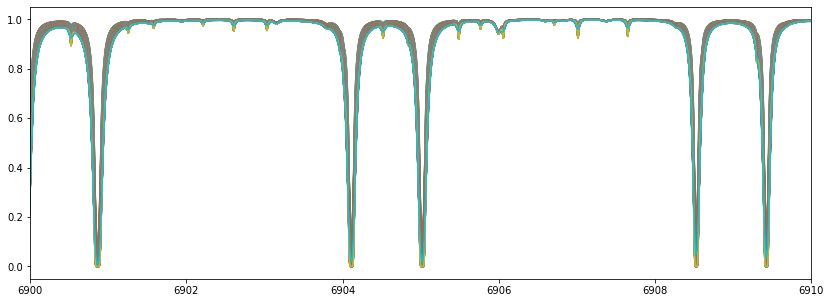

In [6]:
plt.figure(figsize=(14,5))

for h2o in h2o_grid:
    th2o = h2o
    
    
    if (h2o ==38):
        th2o=36.5
    if (h2o ==40):
        th2o=37.1
    if (h2o ==42):
        th2o=44.2
    if (h2o ==44):
        th2o=45.        
              
        
        
        
    for o2 in o2_grid:

        # EXTRA '_' for reading purposes
        outname = DEIMOS_DROPBOX + '/templates/fine_tellurics/telluric_0.02A_h2o_{}_o2_{:2.2f}_.fits'.format(int(h2o),o2)

        print(h2o,o2)
        
        twave = wave_deimos
        if not os.path.isfile(outname):
            tflux = run_telfit(th2o,o2)
            print(outname)

            t = Table([twave,tflux], names=('wave', 'flux'))
            t.meta['h2o'] = h2o
            t.meta['o2']  = o2

            t.write(outname, format='fits')

In [ ]:
clr = ['blue','red']
o2_val  = 1.e5 * np.array([0.7,2.0])
h2o_val = np.array([2,98])
losvd_pix = 0.5/0.01

for h2o in h2o_val:
    
    plt.figure(figsize=(16,5))
    for o2,c in zip(o2_val,clr):
        tfile = DEIMOS_DROPBOX + '/templates/fine_tellurics/telluric_0.02A_h2o_{}_o2_{:2.2f}_.fits'.format(int(h2o),o2/1.e5)
        
        hdu  = fits.open(tfile)
        data =  hdu[1].data
        twave = np.array(data['wave']).flatten()
        tflux = np.array(data['flux']).flatten()

        cflux = scipynd.gaussian_filter1d(tflux,losvd_pix)#,mode='nearest')
        t = 'o2={:0.2e}   h2o={:0.0f}'.format(o2,h2o)
        plt.plot(twave,cflux,alpha=0.5,label=t,color=c)
        plt.title('Changes in O2')

    plt.legend()
#plt.xlim(8200,8500)

In [ ]:
clr = ['blue','red']

for o2 in o2_val:
    
    plt.figure(figsize=(16,5))
    for h2o,c in zip(h2o_val,clr):
        tfile = DEIMOS_DROPBOX + '/templates/fine_tellurics/telluric_0.02A_h2o_{}_o2_{:2.2f}_.fits'.format(int(h2o),o2/1.e5)
        
        hdu  = fits.open(tfile)
        data =  hdu[1].data
        twave = np.array(data['wave']).flatten()
        tflux = np.array(data['flux']).flatten()

 
        cflux = scipynd.gaussian_filter1d(tflux,losvd_pix)#,mode='nearest')
        plt.plot(twave,cflux,alpha=0.5,color=c)
        t = 'o2={:0.2e}   h2o={:0.0f}'.format(o2,h2o)
        plt.plot(twave,cflux,alpha=0.25,label=t,color=c)
        plt.title('Changes in H2O')
    plt.legend()
   # plt.xlim(8100,8350)